# DYNAMICAL SYSTEMS

# Preliminaries

In [1]:
try:
    import controlSBML as ctl
except:
    !pip -q install controlSBML
    import controlSBML as ctl
from controlSBML.util import makeSimulationTimes
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sympy as sy
import tellurium as te
print("controlSBML version: " + ctl.__version__)

controlSBML version: 0.2.4


# Sequential Pathways

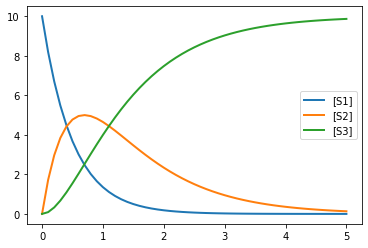

In [2]:
LINEAR_MDL= """
S1 -> S2; k1*S1
S2 -> S3; k2*S2

S1 = 10
S2 = 0
S3 = 0
k1 = 2
k2 = 1
"""
LINEAR_RR = te.loada(LINEAR_MDL)
LINEAR_RR.plot(LINEAR_RR.simulate())

How do we explain this behavior?

For the system $\dot{{\bf x}} (t) = {\bf A} {\bf x}(t)$, the solution is 
${\bf x}(t) = \sum_{n=1}^N c_n {\bf u}_n e^{\lambda_n t}$, where the $c_n$ are computed from ${\bf x})0)$.

In [3]:
# A is the Jacobian
A = LINEAR_RR.getFullJacobian()
ctl.mat2DF(A)

,0,1,2
0,-2.0,0.0,0.0
1,2.0,-1.0,0.0
2,0.0,1.0,0.0


In [4]:
eigenvalues, eigenvectors = np.linalg.eig(A)
ctl.mat2DF(eigenvalues, row_names=A.rownames)

,0
S1,0.0
S2,-1.0
S3,-2.0


In [23]:
ctl.mat2DF(eigenvectors, column_names=["0", "-1", "-2"], 
           row_names=["S1", "S2", "S3"])

,0,-1,-2
S1,0.0,0.000000,0.408248
S2,0.0,0.707107,-0.816497
S3,1.0,-0.707107,0.408248


To find the $c_n$, we solve ${\bf U} {\bf c} = {\bf x}(0)$.
Or, ${\bf U}^{-1} {\bf x}(0) = {\bf c}$.

In [6]:
# Note that the eigenvectors are linearly independent. So, the above inverse exists, and 
# we get a unique solution for the linear system.
np.linalg.matrix_rank(eigenvectors)

3

In [7]:
ctl.ppMat(np.linalg.inv(eigenvectors))

          0         1    2
0  1.000000  1.000000  1.0
1  2.828427  1.414214  0.0
2  2.449490  0.000000  0.0


In [8]:
np.matmul(np.linalg.inv(eigenvectors), np.array([10, 0, 0]))

[10.         28.28427125 24.49489743]

In [9]:
def calcX(A, time, x0):
    """
    Calculate the time solution of a linear system with initial values.

    Parameters
    ----------
    A: np.ndarray (N X N)
    time: float
    x0: np.ndarray (N X 1)

    Returns
    -------
    nd.array (N X 1)
    """
    eigenvalues, eigenvectors = np.linalg.eig(A)
    eigenvectors_inv = np.linalg.inv(eigenvectors)
    c_vec = np.matmul(eigenvectors_inv, x0)
    c_mat = np.diag(c_vec)
    result1 = np.matmul(eigenvectors, c_mat)
    exp_vec = np.array([np.e**(time*v) for  v in eigenvalues])
    result = np.matmul(result1, exp_vec)
    return result
    
# TESTS
x0 = np.array([10, 0, 0])
x = calcX(A, 0, x0)
assert(all([np.isclose(x[n], x0[n], 0) for n in range(len(x))]))
assert(x[0] == x0[0])
print("OK!")

OK!


In [10]:
def getXEigens(A, time, x0):
    """
    Calculates the contributions of the different eigenvectors.

    Parameters
    ----------
    A: np.ndarray (N X N)
    time: float
    x0: np.ndarray (N X 1)

    Returns
    -------
    pd.DataFrame
        Column: eigenvalue
        Row: species
    """
    N = np.shape(A)[0]
    eigenvalues, eigenvectors = np.linalg.eig(A)
    eigenvectors_inv = np.linalg.inv(eigenvectors)
    c_vec = np.matmul(eigenvectors_inv, x0)
    weighted_eigens = [c_vec[n]*eigenvectors[:, n] for n in range(N)]
    exp_vec =[np.e**(time*v) for  v in eigenvalues]
    weighted_eigens = [w*e for w, e in zip(weighted_eigens, exp_vec)]
    df = pd.DataFrame(weighted_eigens).transpose()
    if "rownames" in dir(A):
        if len(A.rownames) > 0:
            rownames = A.rownames
        else:
            rownames = None
    else:
        rownames = None
    df.index = rownames
    df.columns = [round(v, 4) for v in eigenvalues]
    df["total"] = df.sum(axis=1)
    return df
    
# TESTS
x0 = np.array([10, 0, 0])
df = getXEigens(A, 1, x0)
assert(isinstance(df, pd.DataFrame))
assert(len(df) > 0)
print("OK!")

OK!


In [20]:
dfss = [[] for n in range(4)]  # Container for the data frames
fuzz = 0.2
# Collect the weighted eigenvalues over time
x0 = np.array([10, 0, 0])
times = makeSimulationTimes(end_time=5)
for time in times:
    df = getXEigens(A, time, x0)
    columns = list(df.columns)
    for idx, col in enumerate(columns):
        col_df = pd.DataFrame(df[col]).transpose()
        dfss[idx].append(col_df)
df_dct = {}
for dfs in dfss:
    df = pd.concat(dfs, axis=0)
    df = df.applymap(lambda v: v + np.random.rand()*fuzz)
    lams = list(df.index)
    if isinstance(lams[0], str):
        lam = lams[0]
    else:
        lam = str(int(lams[0]))
    df.index = times
    df_dct[lam] = ctl.Timeseries(df)

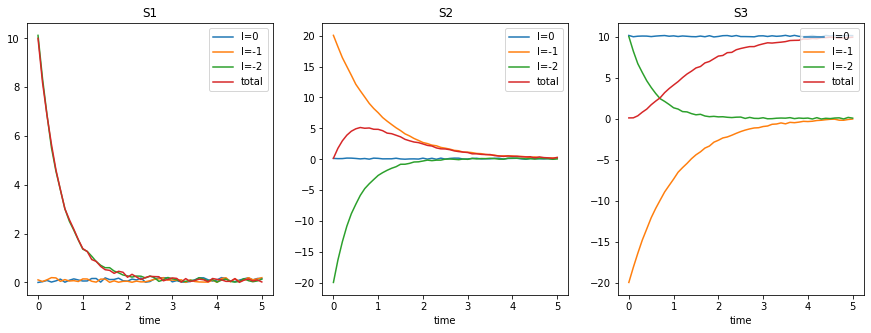

In [21]:
tss = list(df_dct.values())
ctl.plotManyTS(*tss, ncol=3, figsize=(15, 5), names=["l=0", "l=-1", "l=-2", "total"])

In [13]:
# Create 4 Timeseries, one for each eigenvector and one for the total.
# Then create 3 Timeseries, one for each species with a column for each eigenvalue
# Plot over time.
for time in [0, 0.2, 0.5, 1, 2, 4]:
    ctl.ppMat(getXEigens(A, time, x0))

     0.0  -1.0  -2.0         total
S1   0.0   0.0  10.0  1.000000e+01
S2   0.0  20.0 -20.0  0.000000e+00
S3  10.0 -20.0  10.0  1.776357e-15
     0.0       -1.0       -2.0     total
S1   0.0   0.000000   6.703200  6.703200
S2   0.0  16.374615 -13.406401  2.968214
S3  10.0 -16.374615   6.703200  0.328585
     0.0       -1.0      -2.0     total
S1   0.0   0.000000  3.678794  3.678794
S2   0.0  12.130613 -7.357589  4.773024
S3  10.0 -12.130613  3.678794  1.548181
     0.0      -1.0      -2.0     total
S1   0.0  0.000000  1.353353  1.353353
S2   0.0  7.357589 -2.706706  4.650883
S3  10.0 -7.357589  1.353353  3.995764
     0.0      -1.0      -2.0     total
S1   0.0  0.000000  0.183156  0.183156
S2   0.0  2.706706 -0.366313  2.340393
S3  10.0 -2.706706  0.183156  7.476451
     0.0      -1.0      -2.0     total
S1   0.0  0.000000  0.003355  0.003355
S2   0.0  0.366313 -0.006709  0.359604
S3  10.0 -0.366313  0.003355  9.637042


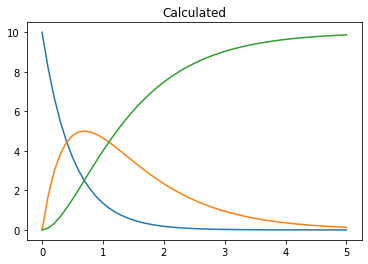

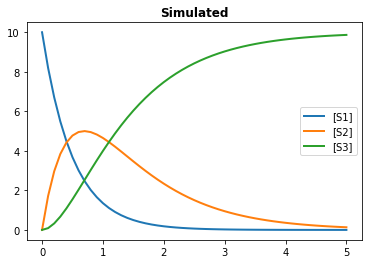

In [14]:
# Compare with Tellurium simulation
times = np.linspace(0, 5, 51)
times
result = np.array([calcX(A, t, x0) for t in times])
plt.plot(times, result)
plt.title("Calculated")
LINEAR_RR.reset()
LINEAR_RR.plot(LINEAR_RR.simulate(), title="Simulated")

# Feedback

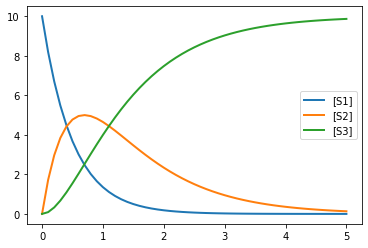

In [15]:
FEEDBACK_MDL= """
S1 -> S2; k1*S1
S2 -> S3; k2*S2
S3 -> S1; k3*S3

S1 = 10
S2 = 0
S3 = 0
k1 = 2
k2 = 1
"""
LINEAR_RR = te.loada(LINEAR_MDL)
LINEAR_RR.plot(LINEAR_RR.simulate())

# Accuracy of Linear Approximations